The Flight.jl package is built upon a hierarchical, causal modeling paradigm. At its core lies the parametric `System` type, which represents a physical system with continuous and (optionally) discrete dynamics.  Every `System` has a continuous state `x`. It may also have an external input `u`, an output `y` and a discrete state `s`.

The `System`'s continuous dynamics are described by a differential equation of the form:
$$
\dot{x} = g(x, u, s, t)
$$

Its output is given by an algebraic equation of the form:
$$
y = h(x, u, s, t)
$$

And its discrete dynamics are described by a difference equation of the form:
$$
s_{k+1} = f_d(s_{k}, u_{k}, x_{k}, t_{k})
$$

A concrete `System` type is specified by means a subtype of the abstract `SystemDescriptor` type. This `SystemDescriptor` serves a dual purpose:
1. It holds the values for all the (immutable) parameters that characterize a specific instance of that `System` type.
2. It provides a dispatch mechanism for extending the set of functions that initialize the `System`'s variables: `x`, `u`, `y` and `s`.

To clarify this, let us consider a simple example: a [mass-spring-damper][1] model.

The response of this system is determined by its mass $m$, its spring constant $k$ and its damping constant $c$. Its continuous dynamics are given by the differential equation:
$$
\dot{v} = f - \omega^2_n p - 2\zeta \omega_n v
$$
$$
\dot{p} = v
$$

In which the following quantities are defined:
- Velocity: $v$
- Position: $p$
- Normalized external force: $f = F/m$
- Undamped natural frequency: $\omega_n = \sqrt{{k}/{m}}$
- Damping ratio: $\zeta = {c}/{2m\omega_n}$

Of these, $\omega_n$ and $\zeta$ are constant parameters, $v$ and $p$ make up the models's continuous state, and $f$ is an external input. As outputs, we may (arbitrarily) select $p$, $v$ and the acceleration $a = \dot{v}$. 

In its vanilla version, the mass-spring-damper model has no need for discrete states. To illustrate a use case for `s`, let's add a twist to the model: we would like the damper to engage only after the system has been in motion for more than $\Delta t_d$ seconds, and disengage again whenever it has been stationary for more than $\Delta t_d$ seconds.

This behavior can be implemented by a simple finite state machine that keeps track of three variables: the damper's state (engaged or disengaged), the last time the system started moving, and the last time it stopped. These clearly represent states in the model, but unlike $v$ or $p$, their evolution is not described by a differential equation. Instead, they are all updated at discrete time steps. Therefore, they belong in the `System`'s discrete state `s`.

This modification also requires two additional parameters: the damper switching interval $\Delta t_d$, and a velocity threshold $v_{\epsilon}$, below which we will consider the system to be stationary.

Now that we have a good idea of what our `System`'s `x`, `u`, `y`, `s` and constant parameters should look like, we can start by defining its `SystemDescriptor` as:

[1]: https://en.wikipedia.org/wiki/Mass-spring-damper_model

In [60]:
using Flight

Base.@kwdef struct MassSpringDamper <: SystemDescriptor
    ω_n::Float64 = 1.0 #undamped natural frequency
    ζ::Float64 = 1.0 #damping ratio
    Δt_d::Float64 = 2 #spring switching time interval
    v_ϵ::Float64 = 1e-6 #velocity threshold
end

MassSpringDamper

Now, to define the `System`'s `x`, `u`, `y` and `s`, we must keep a few rules in mind:
1. `x` must be a subtype of `AbstractArray{Float64}`
2. `u` and `s` can be any mutable types
3. `y` must be an immutable type, and its fields must themselves be immutable as well

While `x` can be defined as a plain `Vector{Float64}`, it is generally a better idea to use a labelled `ComponentVector{Float64}` (provided by the awesome [ComponentArrays.jl][ca] package). In fact, as we will see in future tutorials, when multiple `System`s are composed, their respective continuous state vectors are automatically stacked as ```ComponentVector``` blocks.

`x`, `u` and `s` are preallocated upon initialization and modified in-place during simulation. In contrast, `y` is meant to be logged during simulation, so a new instance of it will be created at every time step. Because mutable types are heap-allocated, making `y` purely immutable is the price to pay to avoid performance detrimental memory allocations.

With all of this in mind, we can define the `System`'s variables through the following type definitions and function extensions:

[ca]: https://github.com/jonniedie/ComponentArrays.jl

In [61]:
using ComponentArrays

Base.@kwdef struct MassSpringDamperY
    p::Float64 = 0.0
    v::Float64 = 0.0
    a::Float64 = 0.0
end

Base.@kwdef mutable struct MassSpringDamperS
    damper_engaged::Bool = false
    t_last_moving::Float64 = 0.0
    t_last_stopped::Float64 = 0.0
end

Systems.init(::SystemX, ::MassSpringDamper) = ComponentVector(p = 0.0, v = 0.0)
Systems.init(::SystemU, ::MassSpringDamper) = Ref(0.0)
Systems.init(::SystemY, ::MassSpringDamper) = MassSpringDamperY()
Systems.init(::SystemS, ::MassSpringDamper) = MassSpringDamperS()

A few comments are in order:
- `SystemX`, `SystemU`, `SystemY` and `SystemD` are empty, trait-like types, used only for dispatch within the `System` constructor. 
- Our `System`'s input (the mass-normalized force $f$) is a scalar. Since a plain `Float64` would be immutable, in order to be able to modify its value during simulation, we wrap it around a `Ref`. Alternatively, we could define a custom mutable type holding a single `Float64`.
- Being immutable, we could also declare `Y` to be a `NamedTuple`, but defining a custom type is more convenient in certain scenarios.
- In this case, we are throwing away the `MassSpringDamper` argument, but if needed we could use it to make the initial values for the `System`'s variables depend on the values of the `MassSpringDamper` parameters.
- If our `System` had no `u`, `y` or `s`, their corresponding method definitions could be omitted and they would be initialized to `nothing` by default. Not so `x`, which is always required.

With this, we can already instantiate our `System`:

In [62]:
sys_desc = MassSpringDamper(; ω_n = 20.0, ζ = 0.4, Δt_d = 1)
sys = System(sys_desc)
@show typeof(sys)
Utils.showfields(sys) #show the type's fields with their current values

typeof(sys) = System{MassSpringDamper, ComponentVector{Float64, Vector{Float64}, Tuple{Axis{(p = 1, v = 2)}}}, MassSpringDamperY, Base.RefValue{Float64}, MassSpringDamperS, NamedTuple{(:ω_n, :ζ, :Δt_d, :v_ϵ), NTuple{4, Float64}}, NamedTuple{(), Tuple{}}}
ẋ: (p = 0.0, v = 0.0)
x: (p = 0.0, v = 0.0)
y: MassSpringDamperY(0.0, 0.0, 0.0)
u: Base.RefValue{Float64}(0.0)
s: MassSpringDamperS(false, 0.0, 0.0)
t: Base.RefValue{Float64}(0.0)
params: (ω_n = 20.0, ζ = 0.4, Δt_d = 1.0, v_ϵ = 1.0e-6)
subsystems: NamedTuple()


We can see that all the `System`'s variables have been allocated as specified by our methods, and the parameters for this particular `MassSpringDamper` instance are now available to us in the `System`'s `params` field. Note the `System`'s time `t` is also stored as a `Ref`.

The only missing piece is the `System`'s continuous and discrete dynamics. These are defined by two additional function extensions:

In [63]:
using UnPack

function Systems.f_ode!(sys::System{<:MassSpringDamper}) 
    
    @unpack x, u, s, params = sys
    @unpack p, v = x
    @unpack ω_n, ζ = params

    f = u[] #de-reference u to get the underlying Float64
    ζ *= s.damper_engaged
    a = f - ω_n^2 * p - 2ζ * ω_n * v
    
    #update sys.ẋ
    sys.ẋ.v = a
    sys.ẋ.p = v

    #update sys.y (cannot be mutated, we need to assign a new instance to it)
    sys.y = MassSpringDamperY(; p, v, a) 
end

#no discrete dynamics
function Systems.f_step!(sys::System{<:MassSpringDamper})

    @unpack x, s, t, params = sys
    @unpack Δt_d, v_ϵ = params

    #t also needs to be de-referenced
    abs(x.v) > v_ϵ ? s.t_last_moving = t[] : s.t_last_stopped = t[]
    
    Δt_stopped = t[] - s.t_last_moving
    Δt_moving = t[] - s.t_last_stopped

    if s.damper_engaged
        Δt_stopped > Δt_d ? s.damper_engaged = false : nothing
    else #!s.damper_engaged
        Δt_moving > Δt_d ? s.damper_engaged = true : nothing
    end

    return false
end


Function `f_ode!` packs the `System`'s continuous dynamics $\dot{x} = g(x,u,s,t)$ and observation equation $y = h(x,u,s,t)$ into a single equation $(\dot{x}, y) = f(x, u, s, t)$. This is a design decision. It is motivated by the fact that, for many complex physical systems in this package, $\dot{x}$ and $y$ share lots of intermediate computations, which would have to be performed twice were $g$ and $h$ defined in separate methods.

Function `f_step!` implements the discrete dynamics function $x_{k+1} = f_d(x_{k}, u_{k}, s_{k}, t_{k})$. Therefore, in theory it should only mutate the `System`'s discrete state `s`. However, in certain scenarios it may be useful to modify `x` too at certain discrete epochs. An example of this is the renormalization of unit quaternions or unit vectors in $x$ to correct deviations from their unit norm constraint due to numerical error. The `Bool` return value of `f_step!` declares whether it has modified `x`.

For safety reasons, no trivial fallback methods are provided for `f_ode!` and `f_step!`. They must be extended for every `System`, even if it has no continuous or discrete dynamics. This is how to extend them in a trivial case:

In [64]:
struct NoContinuousDynamics <: SystemDescriptor end
struct NoDiscreteDynamics <: SystemDescriptor end

Systems.f_ode!(::System{NoContinuousDynamics}, args...; kwargs...) = nothing
Systems.f_step!(::System{NoDiscreteDynamics}, args...; kwargs...) = false


Let's do some quick tests to make sure everything works as expected and our methods are non-allocating:

In [54]:
using BenchmarkTools

sys.u[] = 0.0
f_ode!(sys)
@show sys.ẋ
Utils.showfields(sys.y)

sys.u[] = 1.0
f_ode!(sys)
@show sys.ẋ
Utils.showfields(sys.y)

@assert @ballocated(f_ode!($sys)) == 0
@assert @ballocated(f_step!($sys)) == 0


sys.ẋ = (p = 0.0, v = 0.0)
p: 0.0
v: 0.0
a: 0.0
sys.ẋ = (p = 0.0, v = 1.0)
p: 0.0
v: 0.0
a: 1.0


Now we are ready to simulate our `System`. For this, we create a `Simulation`:

In [55]:
sim = Simulation(sys);

A `Simulation` is a parametric type that couples a `System` with a `OrdinaryDiffEq.ODEIntegrator`. It hooks into the `ODEIntegrator` interface to update the `System`'s internal variables, while adding a bit of machinery to ease user interaction with the `System` during and after simulation. Most of this is done via function wrappers and `DiffEqCallbacks`.

Any ODE algorithm in the `OrdinaryDiffEq` ecosystem can be used for numerical integration. However, fixed-step algorithms are typically preferred for aircraft simulation, because many aircraft systems have discrete dynamics that require a fixed update period (think, for example, of a control law or filter discretized for digital implementation). By default, a `Simulation` chooses a RK4 algorithm. 

`Simulation` extends the `SciMLBase.step!` function, which works like it does for an `ODEIntegrator`. It also defines a `run!` function, which is equivalent to `SciMLBase.solve!`, but allows pacing the integrator for pseudo-real time execution.

The initial values for `x`, `u` and `s` are those held by the `System` when it is passed to the `Simulation` constructor. `Simulation` does not provide a `reinit!` function; the safest and most convenient way to run a simulation more than once is to set up a function that initializes the `System`'s `x`, `u` and `s` to their desired values, and then instantiate a new simulation from it. Of course, if the default values set by the initialization methods are good enough, the `System` can simply be recreated from its descriptor.

In [56]:
sim = Simulation(System(sys_desc); t_end = 10) #instantiate a new simulation using the System's default x, u and s
sim.u[] = 1.0 #we can access the underlying System's fields directly 
step!(sim, 5.0, true) #step the simulation to t = 5.0 and stop
sim.u[] = 0.0 #release the external force
step!(sim, 10) #step to the end

By default, the `Simulation` logs the `System`'s output `y` at every time step. To retrieve it, we simply do:

In [57]:
th = TimeHistory(sim);

The `TimeHistory` type groups an array of logged values with its corresponding array of simulation times. Here are some examples of what it supports:

typeof(th) = TimeHistory{MassSpringDamperY, Vector{Float64}, Vector{MassSpringDamperY}}
length(th) = 501
length(th_3) = 350
typeof(th_p) = TimeHistory{Float64, Vector{Float64}, Vector{Float64}}


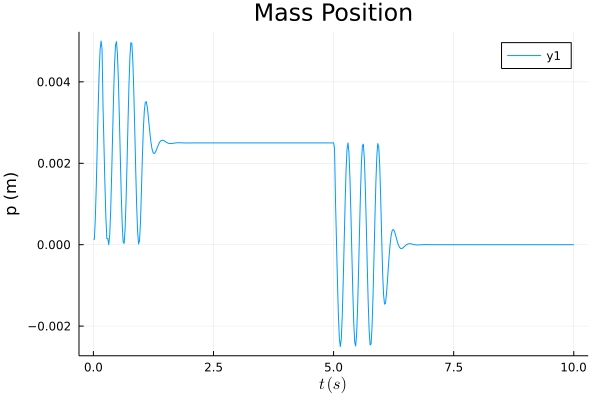

In [58]:
@show typeof(th)
@show length(th)

t = timestamps(th)

th_3 = th[t .> 3]; #can be indexed into
@show length(th_3)

th_p = th.p #accessing a field of the logged type returns a TimeHistory for that field
@show typeof(th_p)

#default Plot recipes are provided for TimeHistory{<:Real} and TimeHistory{<:AbstractVector{<:Real}}
using Plots
plot(th_p; plot_title = "Mass Position", ylabel = "p (m)") #plot position